## Real Datasets - MNIST dataset

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [109]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, labels, create_figure=True, title=None, ax=None, fig=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if create_figure:
        fig = plt.figure(figsize=figsize)

    if ax is None:
        ax = plt.subplot(111)

    ax.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        #plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
        ax.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)

            plt.xticks([]), plt.yticks([])
            ax.axis('off')
    if title is not None:
        #plt.title(title)
        ax.set_title(title)
    if savetitle:
        #plt.savefig(savetitle, transparent = True)
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(savetitle + ".png", transparent = True, bbox_inches=extent)
        plt.savefig(savetitle + ".pdf", transparent = True, bbox_inches=extent)
        
def old_plot_embedding_cons_par(X, labels_cons, labels_par, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax1.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_cons[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax1.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')
        
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax2.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_par[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax2.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.title('Highest NMI with Consensus Clustering')
    ax1.axis('off')
    ax2.axis('off')
    plt.tight_layout()
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [110]:
def plot_embedding_cons_par(X, 
                            labels_cons, labels_nmi, labels_anmi, 
                            title_cons=None, title_nmi=None, title_anmi=None, 
                            savetitle_cons=None, savetitle_nmi=None, savetitle_anmi=None, 
                            figsize=(16,6)):
    fig, axarr = plt.subplots(1, 3, figsize=figsize)
    plot_embedding(X, labels_cons, create_figure=False, title=title_cons, ax=axarr[0], fig=fig, figsize=None, savetitle=savetitle_cons)
    plot_embedding(X, labels_nmi,  create_figure=False, title=title_nmi,  ax=axarr[1], fig=fig, figsize=None, savetitle=savetitle_nmi)
    plot_embedding(X, labels_anmi, create_figure=False, title=title_anmi, ax=axarr[2], fig=fig, figsize=None, savetitle=savetitle_anmi)

In [111]:
np.shape(X)

(1083, 64)

In [112]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [113]:
def plot_results(data, cl_objects, nmi_arr, anmi_arr, consensus_obj, algorithm, arr_x, arr_y, savetitle = None):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) #+ 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) #+ 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param #+ 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row #-1
        ax.axis('off')
 
        ax.set_aspect('equal')
        ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i].astype(int), cmap='Set2', alpha=0.2)
        if algorithm == 'kmeans':
            ax.set_title('k = {:}, \nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[i], nmi_arr[i], anmi_arr[i]))
        elif algorithm == 'meanshift':
            ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i], anmi_arr[i]))
        elif algorithm == 'dbscan':
            ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i], anmi_arr[i]))
        else:
            print("ERROR: Could not recognize algorithm parameter!")
            break
    plt.tight_layout()
    plt.show()
    if savetitle:
        fig.savefig(savetitle + ".png",transparent = True)
        fig.savefig(savetitle + ".pdf",transparent = True)

In [114]:
def old_anmi(consensus_obj, labels):
    ''' calculates nmi of every clustering with every other clustering. 
    here the clusterings we are considering are the set of clusterings 
    (with labelling in the label vector) and the consensus clustering (consensus_obj)
    
    Johannes: consensus-object already provides anmi-functionality. Refactor this to prevent errors
    in the ANMI-calculations below...
    '''
    obj_count=len(labels)+1 #number of clusterings plus the consensus clustering
    nmi_matrix=np.zeros((obj_count,obj_count)) #nmi matrix, note nmi is symmetric
    labels_all=np.concatenate((np.array(labels),np.reshape(consensus_obj.cluster_labels,(1,consensus_obj.cluster_labels.shape[0]))),axis=0)
    for j in range(obj_count):
        for k in range(j+1,obj_count):
            nmi_matrix[k,j]=consensus_obj.compute_nmi(labels_all[j],labels_all[k])
            nmi_matrix[j,k]=nmi_matrix[k,j]
        
    anmi_vector = np.sum(nmi_matrix,axis=0)/(obj_count-1)
    return nmi_matrix, anmi_vector

In [115]:
def anmi(consensus_obj, clustering_objects):
    ''' calculates nmi of every clustering with every other clustering. 
    Then, also calculates the vector of anmis of every clustering from that.
    '''
    n_clusterings = len(clustering_objects)
    nmi_matrix=np.zeros((n_clusterings, n_clusterings)) #nmi matrix, note nmi is symmetric
    for i, obj_i in enumerate(clustering_objects):
        for j, obj_j in enumerate(clustering_objects):
            nmi_matrix[i, j] = consensus_obj.compute_nmi(np.array(obj_i.cluster_labels).astype(int), np.array(obj_j.cluster_labels).astype(int))
            nmi_matrix[j, i] = nmi_matrix[j, i]
    
    return nmi_matrix, np.mean(nmi_matrix, axis=0)

In [116]:
from sklearn.manifold import TSNE

In [117]:
params = dict(n_components=2, 
          perplexity=30.0, 
          early_exaggeration=5.0, 
          learning_rate=70.0, 
          n_iter=1000, 
          n_iter_without_progress=30, 
          min_grad_norm=1e-07, 
          metric='cityblock', 
          init='random', 
          verbose=0, 
          random_state=None, 
          method='barnes_hut', 
          angle=0.5
             )
tsne = TSNE(**params)
X_tsne = tsne.fit_transform(X)

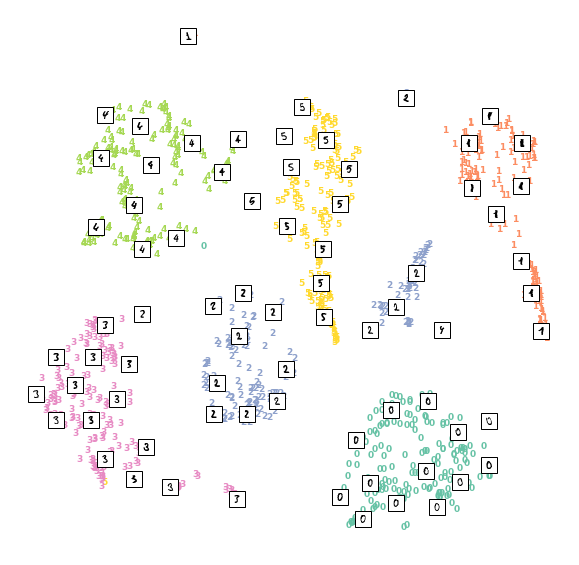

In [118]:
plot_embedding(X_tsne,y,figsize = (10,10))

In [119]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 6
n_min_pts = 6
eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 2
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [120]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 50.0, minPts: 7
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:04.526758
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.18
Consensus clustering terminated.
Finished after 0:00:09.520202
ANMI (average normalized mutual information) of consensus with clusterings: 0.188
Calculate NMI's


## Check ANMI and NMI

In [121]:
nmi_matrix, anmi_vector_db = anmi(consensus_obj_db, cl_objects_db)
print(anmi_vector_db)
print('entry of anmi maximum: ', np.argmax(anmi_vector_db), ' and the anmi of that clustering with the rest: ', max(anmi_vector_db))

[ 0.          0.13920798  0.18699558  0.          0.          0.          0.
  0.14762069  0.18892917  0.          0.          0.          0.
  0.14877267  0.18775216  0.          0.          0.          0.
  0.14205352  0.19271455  0.          0.          0.          0.
  0.13296435  0.19189133  0.06333719  0.          0.          0.
  0.12661029  0.19050471  0.06333719  0.          0.        ]
entry of anmi maximum:  20  and the anmi of that clustering with the rest:  0.192714545729


Number of clusterings: 36


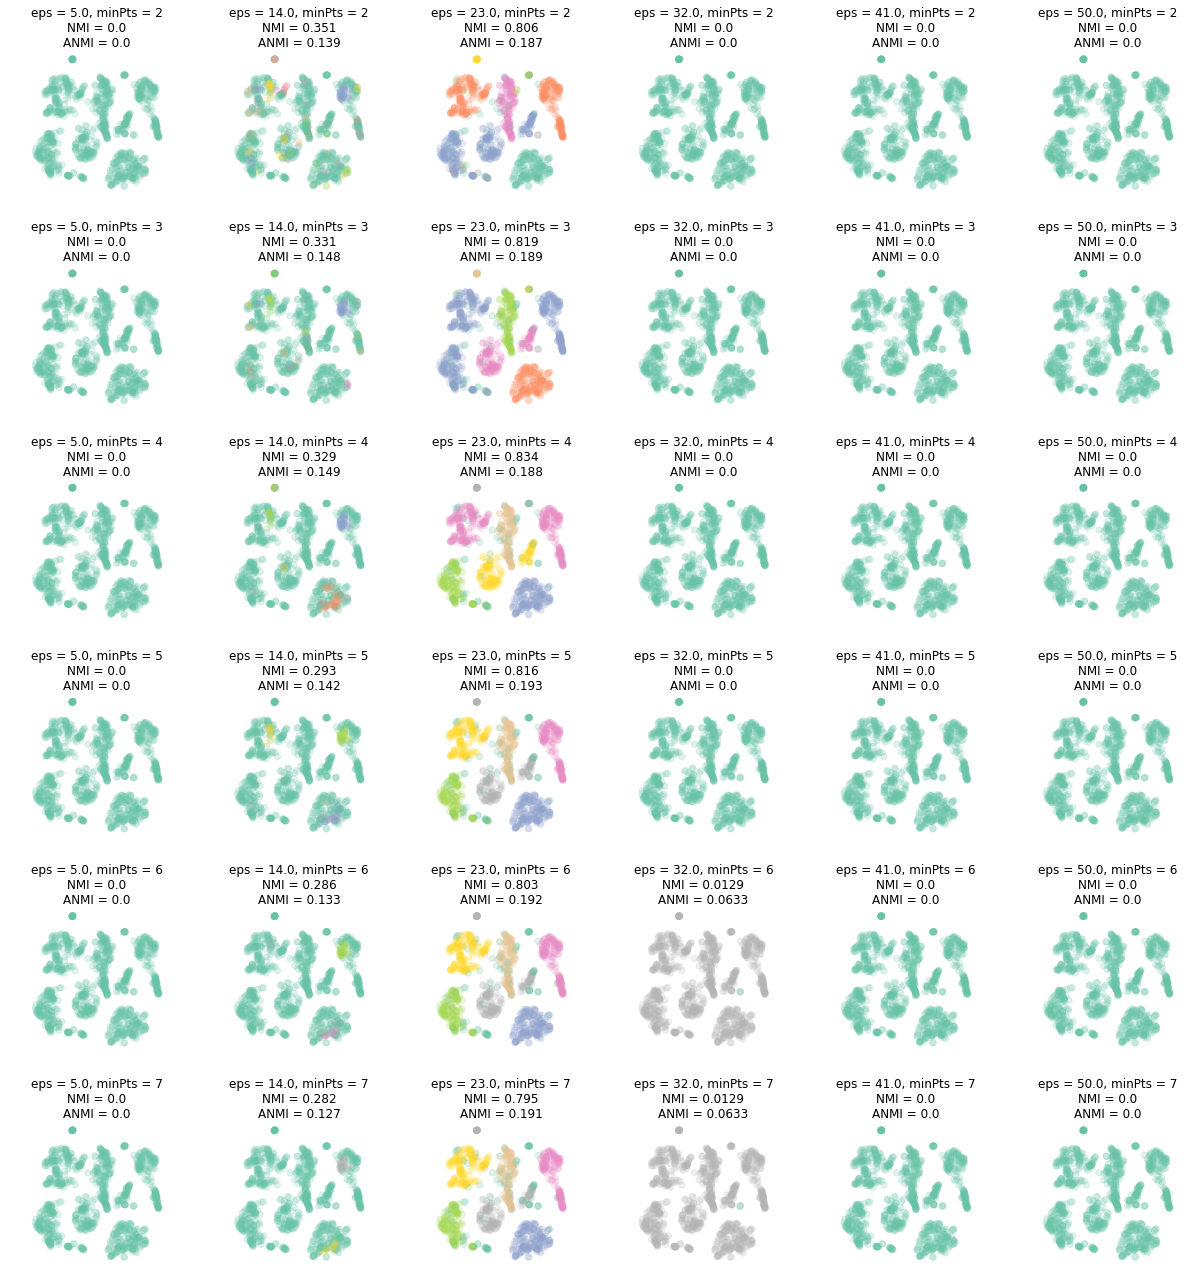

In [122]:
plot_results(data=X_tsne, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, anmi_arr=anmi_vector_db, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr,
            savetitle = 'img/mnist_dbscan_all')

## Consensus clustering result using DBSCAN vs highest NMI result with consensus

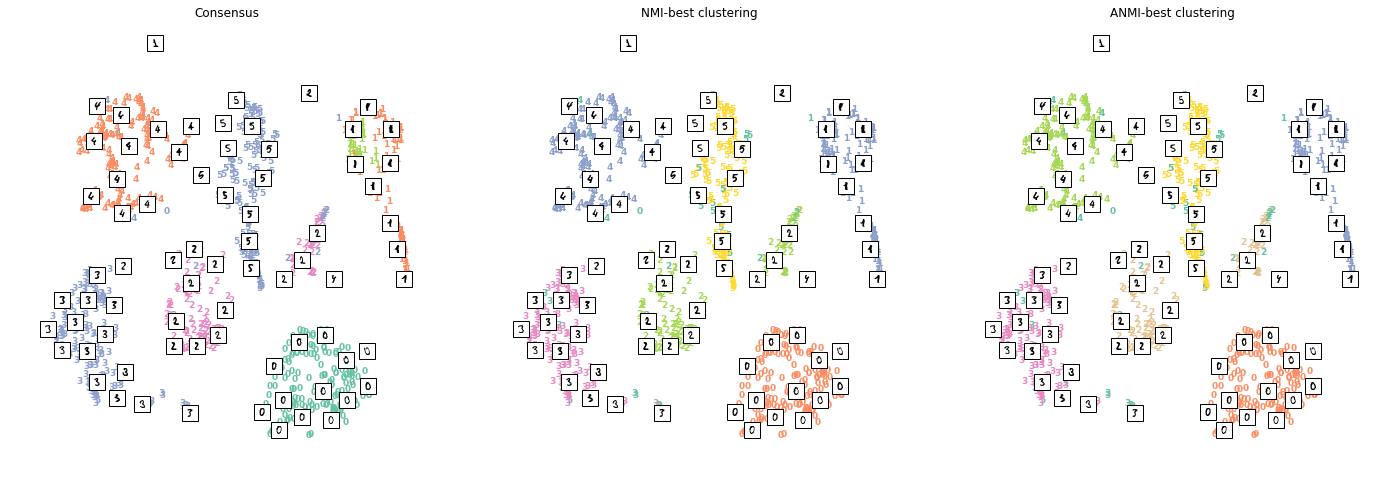

In [123]:
labels_nmi_best = np.array(cl_objects_db[np.argmax(nmi_arr_db)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db[np.argmax(anmi_vector_db)].cluster_labels).astype(int)

plot_embedding_cons_par(X_tsne, 
                        consensus_obj_db.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        title_cons="Consensus", title_nmi="NMI-best clustering", title_anmi="ANMI-best clustering", 
                        figsize = (24,8), savetitle_cons='img/mnist_dbscan_consensus', savetitle_nmi='img/mnist_dbscan_NMI', savetitle_anmi='img/mnist_dbscan_ANMI')

In [124]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[best],", minpts: ", mesh_min_pts.flatten()[best])

The best parameter choice (given the chosen range) has NMI  0.833526902998  compared to the consensus result, the best parameters are then eps:  50.0 , minpts:  5


### MEANSHIFT

In [125]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr, mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [126]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
#n_eps = 6
#n_min_pts = 6
#eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
#min_pts_min = 4
#min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
#mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

n_bandwidths = 5
bw_arr = np.linspace(5, 15.0, n_bandwidths)
mindist_arr = np.linspace(0.02, 0.05, 2) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)

In [127]:
nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidth_arr = mesh_bw.flatten(),
    mindist_arr = mesh_mindist.flatten())

Fit Mean Shift objects
bandwidth: 15.0, mindist: 0.05
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:06.358513
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.44
Consensus clustering terminated.
Finished after 0:00:10.359204
ANMI (average normalized mutual information) of consensus with clusterings: 0.515
Calculate NMI's


## Check ANMI and NMI

In [128]:
nmi_matrix, anmi_vector_ms = anmi(consensus_obj_ms, cl_objects_ms)
print(anmi_vector_ms)
print('entry of anmi maximum: ', np.argmax(anmi_vector_ms), ' and the anmi of that clustering with the rest: ', max(anmi_vector_ms))

[ 0.31681207  0.50691598  0.53694427  0.50012758  0.          0.31947623
  0.51192511  0.53694427  0.50012758  0.        ]
entry of anmi maximum:  2  and the anmi of that clustering with the rest:  0.536944265803


Number of clusterings: 10


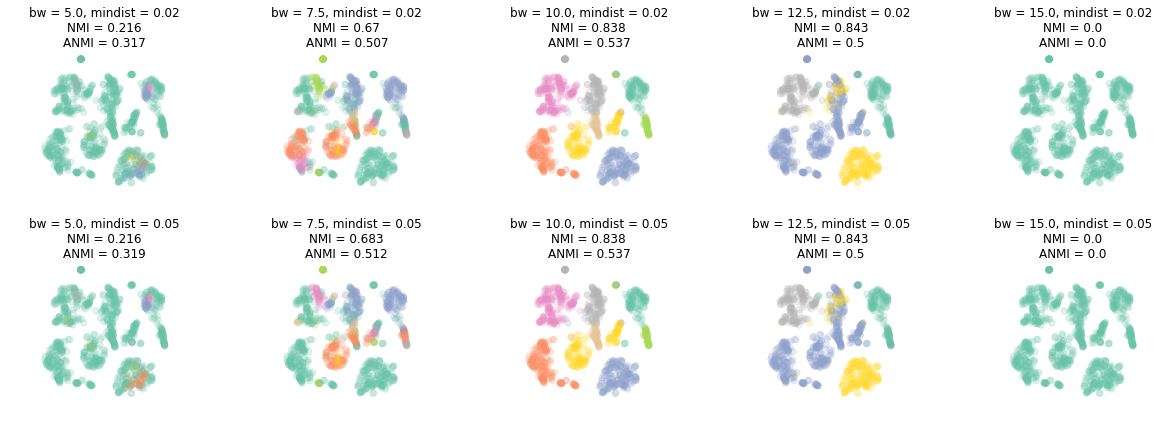

In [129]:
plot_results(data=X_tsne, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, anmi_arr=anmi_vector_ms, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr, savetitle = 'img/mnist_ms_all')

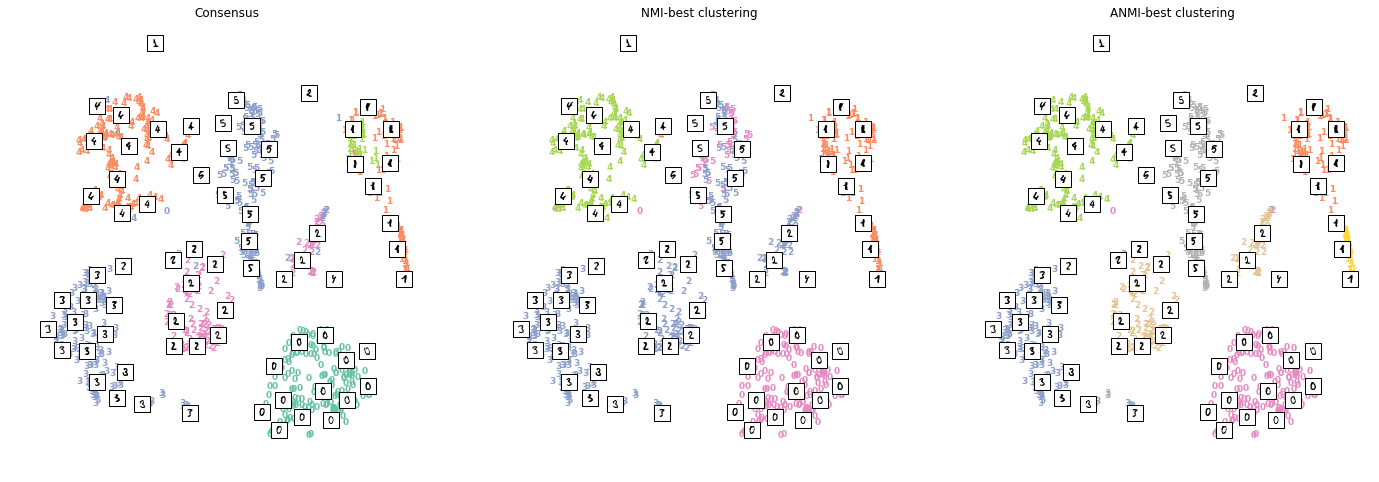

In [130]:
labels_nmi_best = np.array(cl_objects_ms[np.argmax(nmi_arr_ms)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_ms[np.argmax(anmi_vector_ms)].cluster_labels).astype(int)

plot_embedding_cons_par(X_tsne, 
                        consensus_obj_db.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        title_cons="Consensus", title_nmi="NMI-best clustering", title_anmi="ANMI-best clustering", 
                        figsize = (24,8), savetitle_cons='img/mnist_ms_consensus', savetitle_nmi='img/mnist_ms_NMI', savetitle_anmi='img/mnist_ms_ANMI')

In [131]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_ms), " compared to the consensus result, the best parameters are then bandwidth: ",mesh_bw.flatten()[best_ms],", mindist: ", mesh_mindist.flatten()[best_ms])

The best parameter choice (given the chosen range) has NMI  0.842879563042  compared to the consensus result, the best parameters are then bandwidth:  12.5 , mindist:  0.02


# Fuzzy Data (Synthetic)

In [132]:
def old_plot_synth_cons_par(X, labels_cons,labels_par, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_cons[i].astype(int)),s=74,alpha=0.2)

    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')   
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_par[i].astype(int)),s=74,alpha=0.2)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Highest NMI with Consensus Clustering')
    
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [133]:
def plot_synth_cons_par(X, labels_cons, labels_nmi, labels_anmi, figsize=(16,6), savetitle_cons=None, savetitle_nmi=None, savetitle_anmi=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    num_plots = 3
    fig, axarr = plt.subplots(1, num_plots, figsize=figsize)
    
    #for i, ax in enumerate(axarr.flat):
    for ax in axarr.flat:
        ax.axis('off')
    
    # Consensus
    axarr[0].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_cons.astype(int)),s=74,alpha=0.2)
    axarr[0].set_title("Consensus Clustering")
    
    # NMI
    axarr[1].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_nmi.astype(int)),s=74,alpha=0.2)
    axarr[1].set_title("Highest NMI with Consensus Clustering")
    
    # ANMI
    axarr[2].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_anmi.astype(int)),s=74,alpha=0.2)
    axarr[2].set_title("Highest ANMI with Consensus Clustering")
    
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    extents = [axarr[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted()) for i in range(num_plots)]
    
    if savetitle_cons:
        plt.savefig(savetitle_cons + ".png", transparent = True, bbox_inches=extents[0])
        plt.savefig(savetitle_cons + ".pdf", transparent = True, bbox_inches=extents[0])
    if savetitle_nmi:
        plt.savefig(savetitle_nmi + ".png", transparent = True, bbox_inches=extents[1])
        plt.savefig(savetitle_nmi + ".pdf", transparent = True, bbox_inches=extents[1])
    if savetitle_anmi:
        plt.savefig(savetitle_anmi + ".png", transparent = True, bbox_inches=extents[2])
        plt.savefig(savetitle_anmi + ".pdf", transparent = True, bbox_inches=extents[2])

In [134]:
# Set parameters:

# General
from consensus_clustering.load_data import load_fuzzy_data
fuzzy = load_fuzzy_data()
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps = 6
n_min_pts = 5
eps_arr = np.linspace(0.01, 0.10, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 7
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

np.shape(fuzzy)

(2309, 2)

In [135]:
nmi_arr_db_fz, cl_objects_db_fz, consensus_obj_db_fz = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.1, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:01:05.266719
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.22
Consensus clustering terminated.
Finished after 0:01:36.261782
ANMI (average normalized mutual information) of consensus with clusterings: 0.356
Calculate NMI's


## NMI and ANMI

In [136]:
nmi_matrix, anmi_vector_fz = anmi(consensus_obj_db_fz, cl_objects_db_fz)
print(anmi_vector_fz)
print('entry of anmi maximum: ', np.argmax(anmi_vector_fz), ' and the anmi of that clustering with the rest: ', max(anmi_vector_fz))

[ 0.21796488  0.2915514   0.36776024  0.34360684  0.19150348  0.14683184
  0.2165648   0.29898252  0.36927999  0.36500862  0.27104287  0.14683184
  0.20728904  0.29607139  0.36767837  0.36986387  0.28863271  0.14683184
  0.19037259  0.29236049  0.36195883  0.37228649  0.30294348  0.14052052
  0.17251834  0.28661958  0.35803871  0.37222685  0.32538868  0.1693217 ]
entry of anmi maximum:  21  and the anmi of that clustering with the rest:  0.372286488101


Number of clusterings: 30


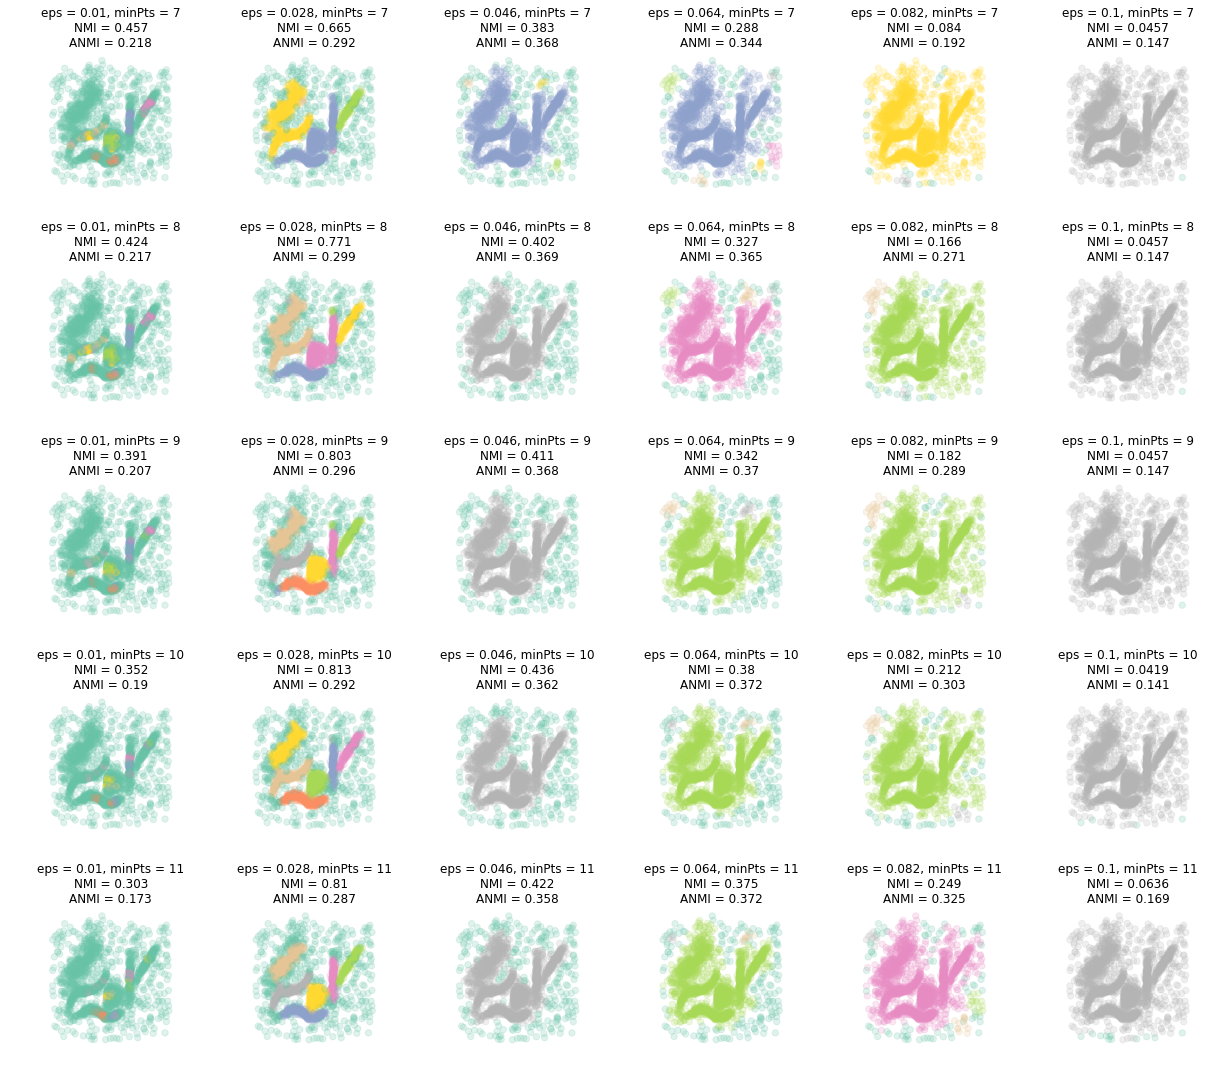

In [137]:
plot_results(data=fuzzy, cl_objects=cl_objects_db_fz, nmi_arr=nmi_arr_db_fz, anmi_arr=anmi_vector_fz, consensus_obj=consensus_obj_db_fz, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr, savetitle = 'img/fuzzy_dbscan_all')

#### The ANMI > 0 in the last column is not a bug:

In [138]:
np.unique(labels[5])

array([1])

In [139]:
len(fuzzy)

2309

In [140]:
len([i for i, label in enumerate(labels[5]) if label == 1])

1083

In [143]:
plot_ind = 5

#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111)
#ax.scatter(fuzzy[:, 0], fuzzy[:, 1], s=40, c=labels[plot_ind].astype(int), cmap='Set1', alpha=1.0)

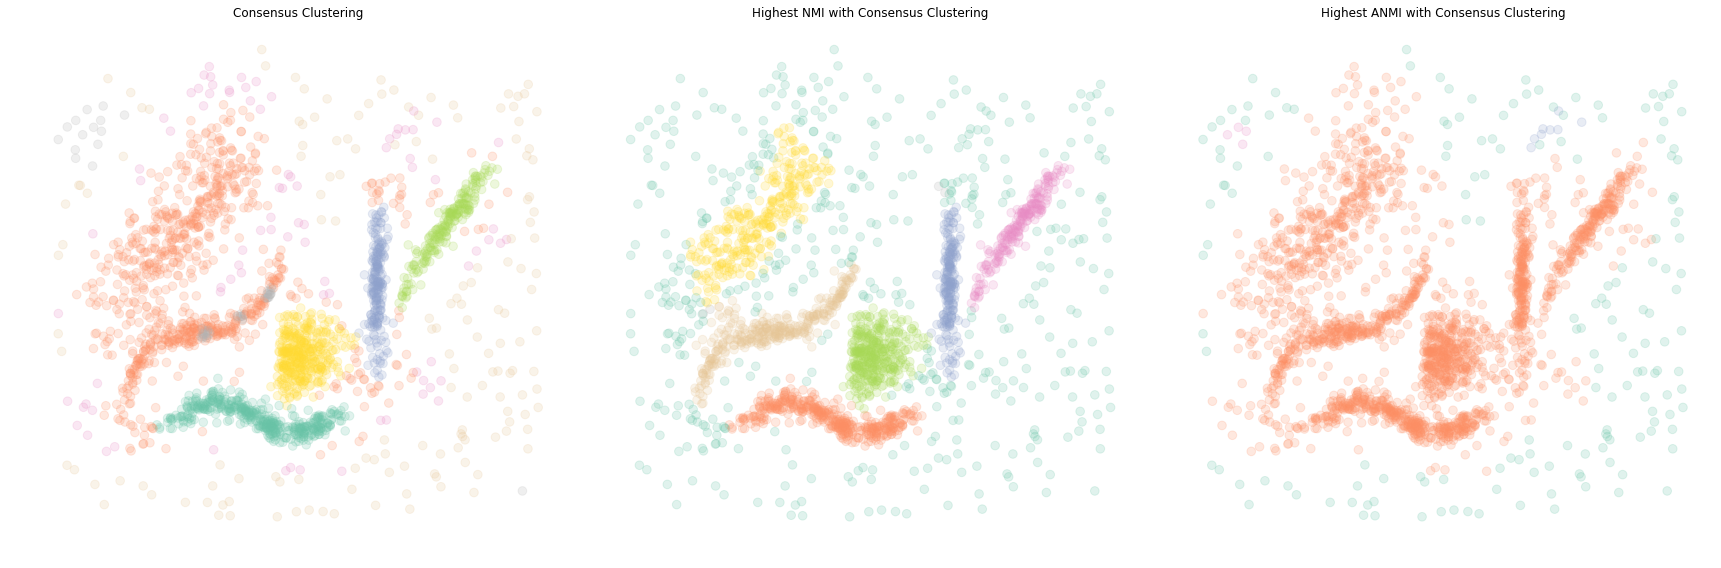

In [144]:
labels_nmi_best = np.array(cl_objects_db_fz[np.argmax(nmi_arr_db_fz)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db_fz[np.argmax(anmi_vector_fz)].cluster_labels).astype(int)

plot_synth_cons_par(fuzzy, 
                        consensus_obj_db_fz.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/fuzzy_dbscan_consensus', savetitle_nmi='img/fuzzy_dbscan_NMI', savetitle_anmi='img/fuzzy_dbscan_ANMI')

In [145]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db_fz), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[best],", minpts: ", mesh_min_pts.flatten()[best])

The best parameter choice (given the chosen range) has NMI  0.813042691197  compared to the consensus result, the best parameters are then eps:  0.1 , minpts:  10


## ROBUSTNESS: Test Methods on rubbish clusterings (ie. bad hyperparameter choices) and rubbish data sets (ie uniformly distributed points in 2D)  

### (1) Test DBSCAN over a range of hyperparameter with DBSCAN on uniformly placed points

In [146]:
datarandom=np.random.random((1000, 3))
# Set parameters:

# General
k_consensus = 5
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps = 6
n_min_pts = 5
eps_arr = np.linspace(0.01, 0.20, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 7
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [147]:
nmi_arr_db_rand, cl_objects_db_rand, consensus_obj_db_rand = param_search_dbscan(
    data = datarandom,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.2, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:04.350701
Stopping cluster number was reached.
Current number of clusters: 5
Current minimum cluster distance: 0.14
Consensus clustering terminated.
Finished after 0:00:07.756235
ANMI (average normalized mutual information) of consensus with clusterings: 0.132
Calculate NMI's


In [148]:
nmi_matrix, anmi_vector_rand = anmi(consensus_obj_db_rand, cl_objects_db_rand)
print(anmi_vector_rand)
print('entry of anmi maximum: ', np.argmax(anmi_vector_rand), ' and the anmi of that clustering with the rest: ', max(anmi_vector_rand))

[ 0.          0.          0.08558863  0.08221067  0.09094525  0.          0.
  0.          0.10244102  0.09744239  0.11015841  0.          0.          0.
  0.10651871  0.10258285  0.12471799  0.          0.          0.
  0.10350115  0.1053204   0.12471799  0.          0.          0.
  0.10350115  0.10079675  0.09934164  0.        ]
entry of anmi maximum:  16  and the anmi of that clustering with the rest:  0.124717992173


Number of clusterings: 30


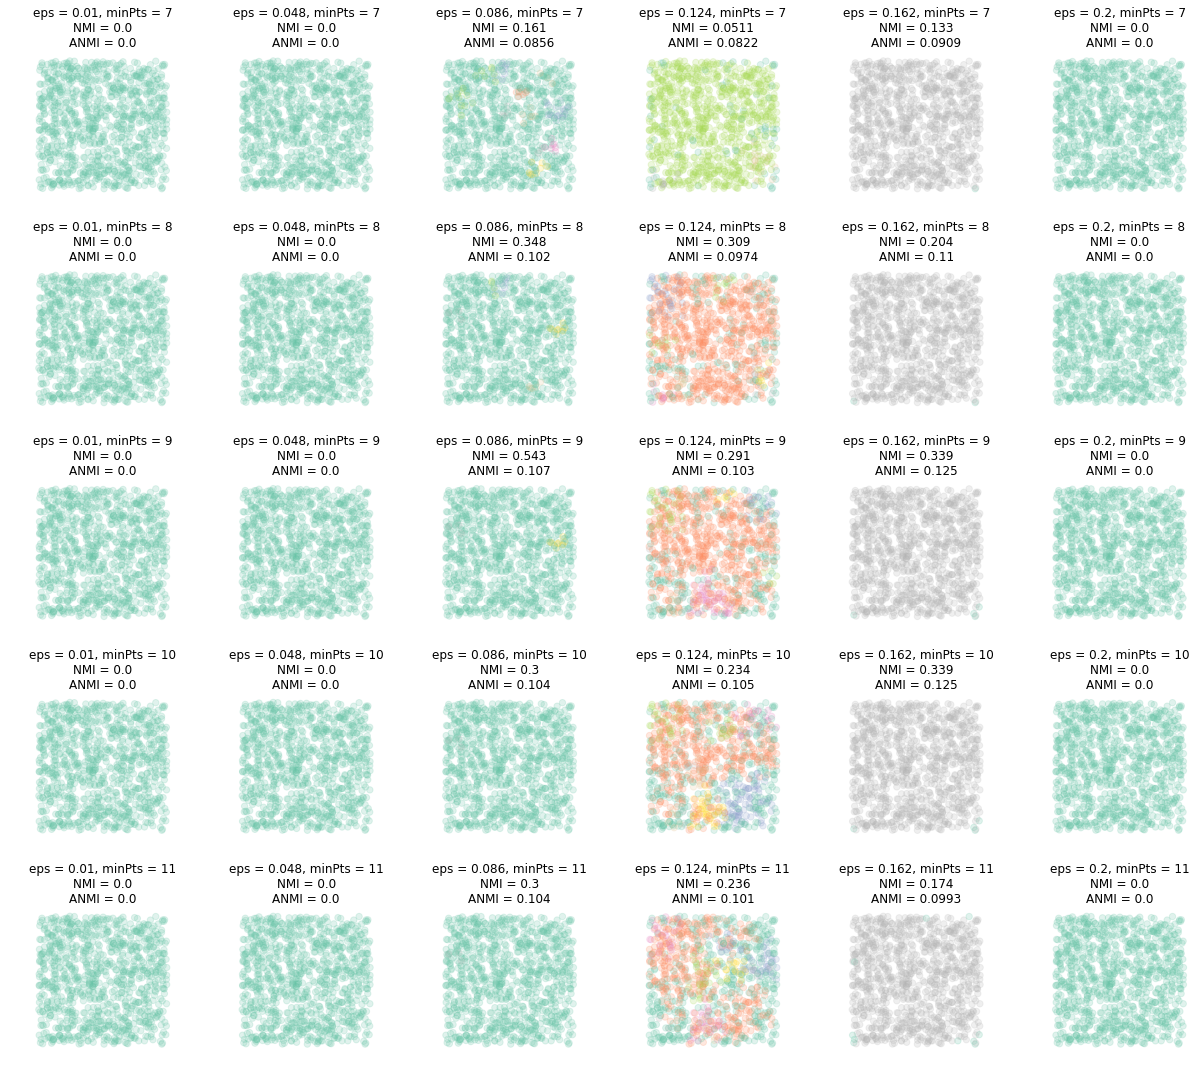

In [149]:
plot_results(data=datarandom, cl_objects=cl_objects_db_rand, nmi_arr=nmi_arr_db_rand, anmi_arr=anmi_vector_rand, consensus_obj=consensus_obj_db_rand, algorithm='dbscan',arr_x=eps_arr, arr_y=min_pts_arr, savetitle = 'img/rand_dbscan_all')

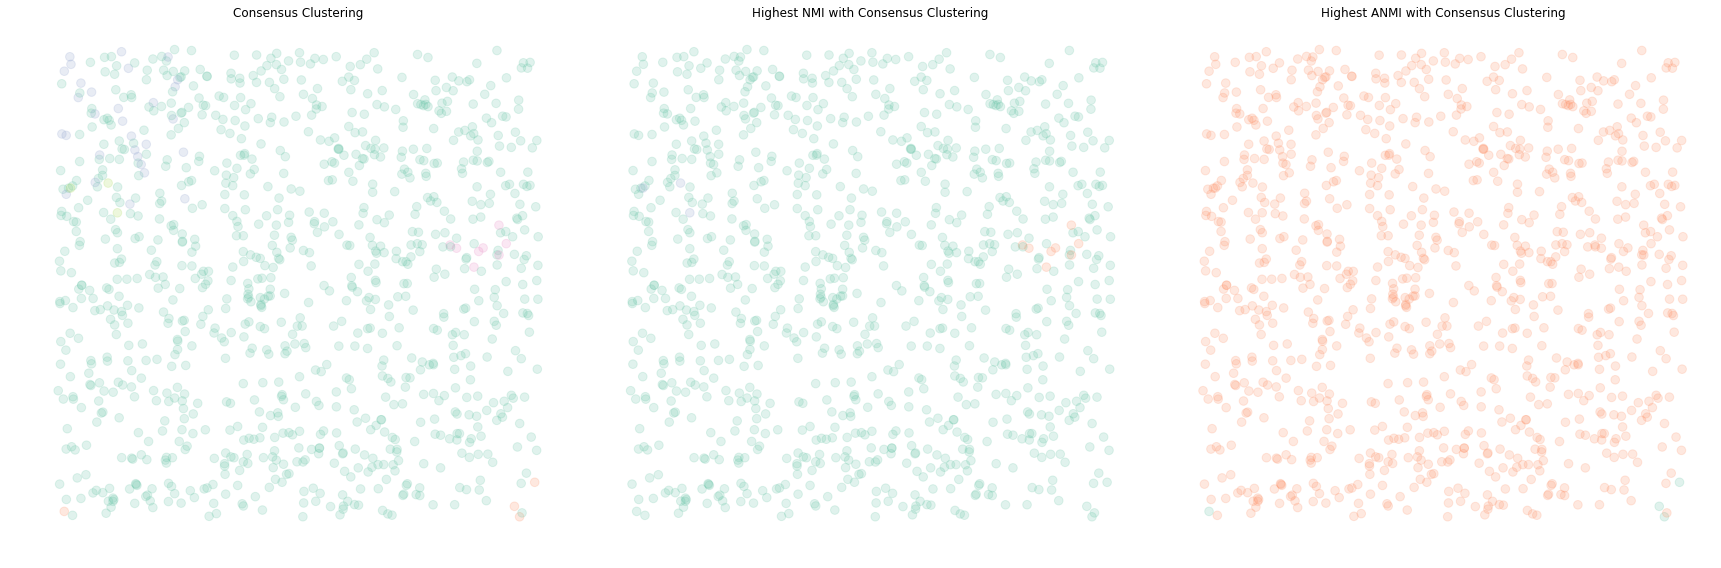

In [150]:
labels_nmi_best = np.array(cl_objects_db_rand[np.argmax(nmi_arr_db_rand)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db_rand[np.argmax(anmi_vector_rand)].cluster_labels).astype(int)

plot_synth_cons_par(datarandom, 
                        consensus_obj_db_rand.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/rand_dbscan_consensus', savetitle_nmi='img/rand_dbscan_NMI', savetitle_anmi='img/rand_dbscan_ANMI')

Remark: The ANMI method realizes that it's all rubbish (no clustered points at all), and thus the value is quite low for all clusterings (below 0.1). Because for the consensus clustering procedure we have to set k, the number of clusters, the consensus has to have k clusters. For finding the NMI-best clustering we only compare the clusterings to the consensus, this doesn't work that well here (the consensus itself is bad). The NMI-best clustering has still quite a high NMI with the consensus (around 0.7). So just from the NMI values we can't guess that it's not a good data set (no structure in the data).

### (2) Now let's try K-means and hyperparameter search on the same data

In [151]:
def param_search_kmeans(data, k_consensus, recluster_what, recluster_how, k_arr):
    num_objects = len(k_arr)
    kmeans_objects = [None] * num_objects
    kmeans_obj = None

    print("Fit kmeans objects")

    # Fit kmeans objects
    for i, k in enumerate(k_arr):
        kmeans_obj = cl_dist.KMeans(data=data, k=k, verbose=False)
        kmeans_obj.fit()
        kmeans_objects[i] = kmeans_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*kmeans_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(kmeans_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, kmeans_objects, consensus_obj

In [152]:
# Set parameters:

# General
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

#KMeans
km_arr = np.arange(1,6)

nmi_arr_km, cl_objects_km, consensus_obj_km = param_search_kmeans(
    data = datarandom,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    k_arr = km_arr)

Fit kmeans objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:04.972830
Stopping cluster number was reached.
Current number of clusters: 3
Current minimum cluster distance: 0.65
Consensus clustering terminated.
Finished after 0:00:05.182145
ANMI (average normalized mutual information) of consensus with clusterings: 0.474
Calculate NMI's


In [153]:
#collect all labellings
#labels = []
#for obj in cl_objects_km:
#    labels.append(consensus_obj_km._noise_to_zero(obj).cluster_labels)

#nmi_matrix, anmi_vector= anmi(consensus_obj_km, labels)
#print(anmi_vector)
#print('entry of anmi maximum: ',np.argmax(anmi_vector), ' and the anmi of that clustering with the rest: ', max(anmi_vector))

In [154]:
nmi_matrix, anmi_vector_rand_km = anmi(consensus_obj_km, cl_objects_km)
print(anmi_vector_rand_km)
print('entry of anmi maximum: ', np.argmax(anmi_vector_rand_km), ' and the anmi of that clustering with the rest: ', max(anmi_vector_rand_km))

[ 0.          0.4145116   0.47890219  0.48656566  0.48394224]
entry of anmi maximum:  3  and the anmi of that clustering with the rest:  0.486565661667


Number of clusterings: 5


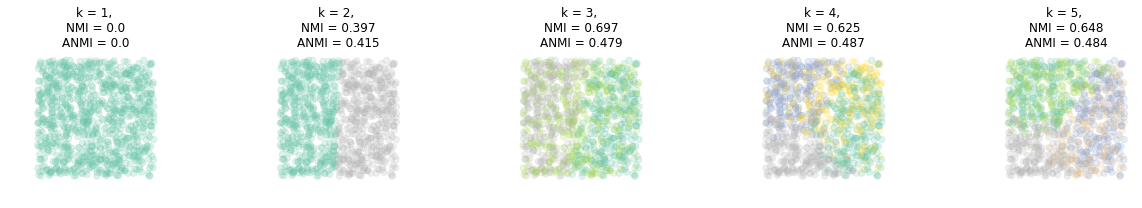

In [155]:
plot_results(data=datarandom, cl_objects=cl_objects_km, nmi_arr=nmi_arr_km, anmi_arr=anmi_vector_rand_km,consensus_obj=consensus_obj_km, algorithm='kmeans',  arr_x=km_arr, arr_y=np.zeros(1), savetitle = 'img/rand_km_all')

In [156]:
#highest NMI with consensus
#best=np.argmax(nmi_arr_km)

#obj=cl_objects_km[best]
#labels_parametersearch_km=consensus_obj_km._noise_to_zero(obj).cluster_labels

#plot_synth_cons_par(datarandom,consensus_obj_km.cluster_labels.astype(int),labels_parametersearch_km,figsize = (20,10),savetitle_cons = 'img/rand_km_consensus', savetitle_par = 'img/rand_km_NMI')

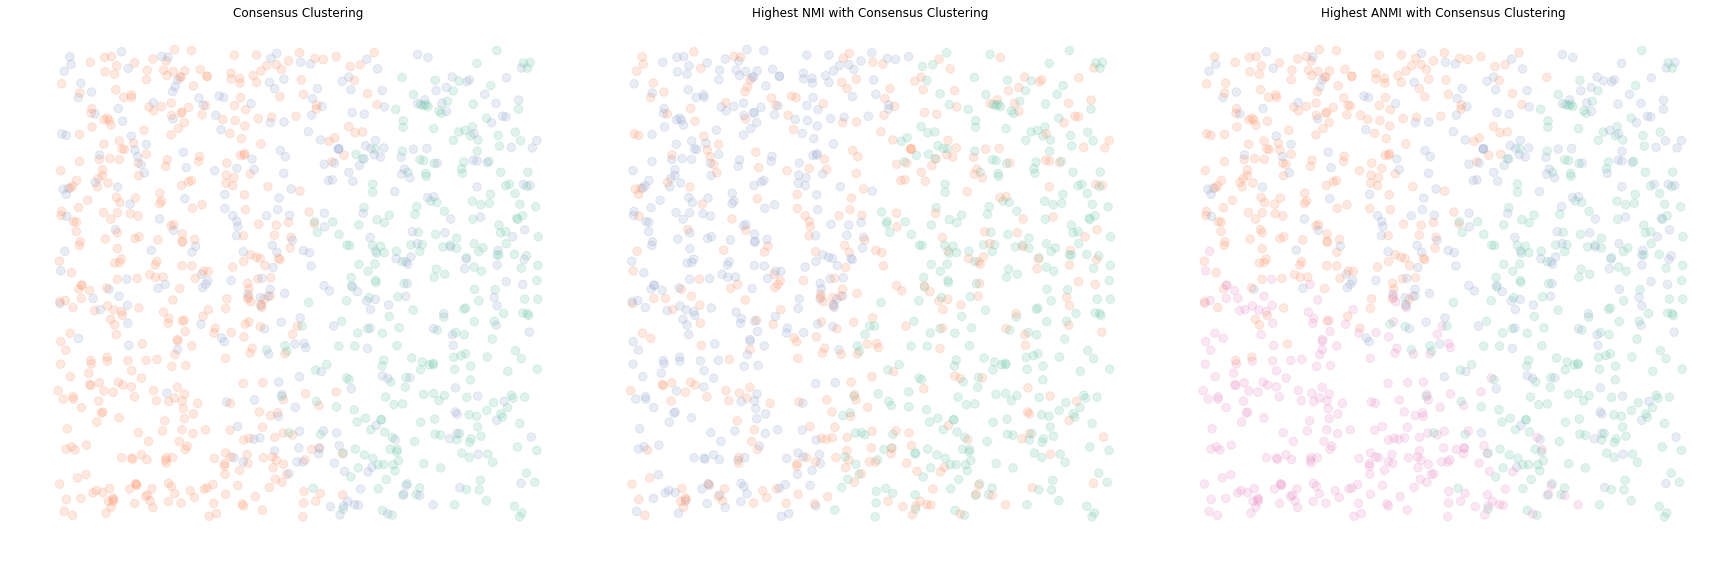

In [157]:
labels_nmi_best = np.array(cl_objects_km[np.argmax(nmi_arr_km)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_km[np.argmax(anmi_vector_rand_km)].cluster_labels).astype(int)

plot_synth_cons_par(datarandom, 
                        consensus_obj_km.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/rand_km_consensus', savetitle_nmi='img/rand_km_NMI', savetitle_anmi='img/rand_km_ANMI')

Remark: Both NMI-best and ANMI-best methods perform badly. They both don't indicate that the data set or found clusters are rubbish.

### (3) Now a different experiment: what happens if the grid of clusterings doesn't contain any reasonable hyperparameters. We'll take the fuzzy data set and DBCAN again.

In [158]:
# Set parameters:

# General
from consensus_clustering.load_data import load_fuzzy_data
fuzzy = load_fuzzy_data()
k_consensus_bad = 20
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps_bad = 6
n_min_pts_bad = 5
eps_arr_bad = np.linspace(0.001, 0.01, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min_bad = 7
min_pts_arr_bad = np.arange(min_pts_min_bad, min_pts_min_bad + n_min_pts_bad)
mesh_eps_bad, mesh_min_pts_bad = np.meshgrid(eps_arr_bad, min_pts_arr_bad)

In [159]:
nmi_arr_db_bad, cl_objects_db_bad, consensus_obj_db_bad = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus_bad,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps_bad.flatten(),
    min_pts_arr = mesh_min_pts_bad.flatten())

Fit DBSCAN objects
eps: 0.01, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:50.471271
Stopping cluster number was reached.
Current number of clusters: 20
Current minimum cluster distance: 0.2
Consensus clustering terminated.
Finished after 0:01:39.342647
ANMI (average normalized mutual information) of consensus with clusterings: 0.282
Calculate NMI's


In [160]:
nmi_matrix, anmi_vector_bad_fz = anmi(consensus_obj_db_bad, cl_objects_db_bad)
print(anmi_vector_bad_fz)
print('entry of anmi maximum: ', np.argmax(anmi_vector_bad_fz), ' and the anmi of that clustering with the rest: ', max(anmi_vector_bad_fz))

[ 0.          0.          0.12727783  0.26341914  0.26668732  0.2205907   0.
  0.          0.          0.25832487  0.2784691   0.24005026  0.          0.
  0.          0.23740955  0.28234646  0.25964784  0.          0.          0.
  0.22133191  0.27562007  0.27033934  0.          0.          0.
  0.12881161  0.27024355  0.27354472]
entry of anmi maximum:  16  and the anmi of that clustering with the rest:  0.28234646048


Number of clusterings: 30


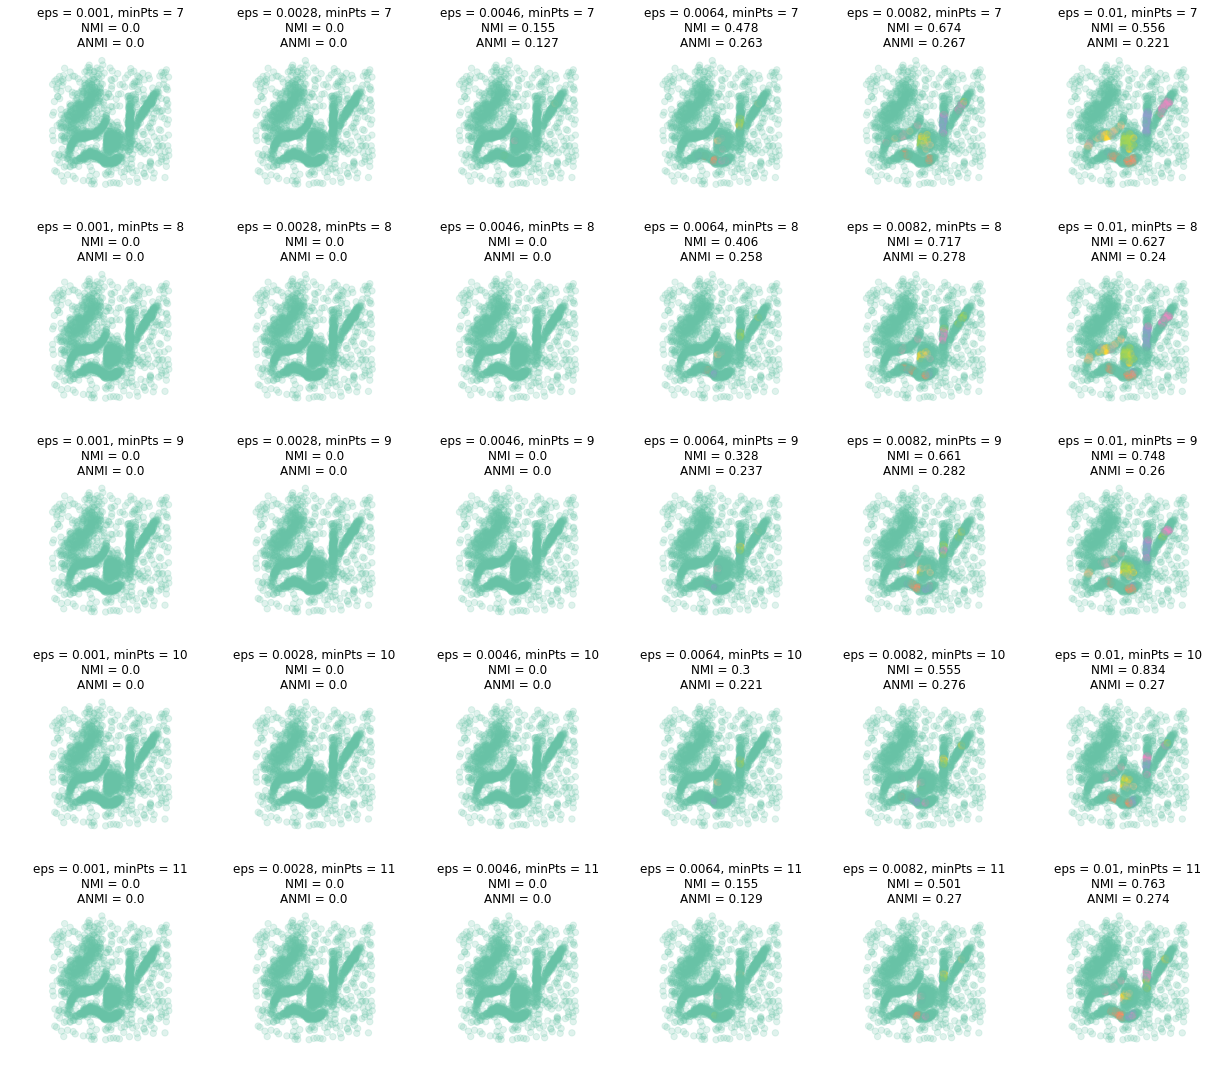

In [161]:
plot_results(data=fuzzy, cl_objects=cl_objects_db_bad, nmi_arr=nmi_arr_db_bad, anmi_arr=anmi_vector_bad_fz, consensus_obj=consensus_obj_db_bad, algorithm='dbscan', arr_x=eps_arr_bad, arr_y=min_pts_arr_bad, savetitle = 'img/fuzzy_baddbscan_all')

In [162]:
labels_nmi_best = np.array(cl_objects_db_bad[np.argmax(nmi_arr_db_bad)].cluster_labels).astype(int)
labels_anmi_best = np.array(cl_objects_db_bad[np.argmax(anmi_vector_bad_fz)].cluster_labels).astype(int)

plot_synth_cons_par(fuzzy, 
                        consensus_obj_db_bad.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/fuzzy_baddbscan_consensus', savetitle_nmi='img/fuzzy_baddbscan_NMI', savetitle_anmi='img/fuzzy_baddbscan_ANMI')

Remark: Here again the consensus isn't good (not surprising). thus choosing the clustering with the highest NMI doesn't yield a reasonable result. 
But the fact that the ANMI is quite low throughout (below 0.3), indicates that the set of clusterings doesn't contain any good clustering results.